#### Эксперимент с новой системой рекомендаций будет проходить с 2024-05-03 по 2024-05-09
#### Группа 1 - контрольная.
#### Группа 2 - тестовая, для нее будет применен новый алгоритм.
#### Нулевая гипотеза: применение нового алгоритма рекомендаций не окажет влияние на CTR.
#### Альтернативная гипотеза: применение нового алгоритма рекомендаций приведет к увеличению CTR.
Для начала проверим систему сплитования, для этого проведем АА-тесты. Важно, чтобы группы перед проведением эксперимента были статистически эквивалентны.
Возьмем данные пользователей рассматриваемых групп с 2024-04-26 по 2024-05-02, будем сэмплировать по 500 пользователей из полученных выборок без повторения и проводить t-тест для каждой такой подвыборки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
from scipy import stats
import hashlib
import random
from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
load_dotenv()

#параметры соединения
connection = {'host': os.getenv('HOST'),
'database': os.getenv('DATABASE'),
'user': os.getenv('USER'),
'password': os.getenv('PASSWORD')
}

In [3]:
#функция сплитования
my_salt = 'exp_mess_1'
def AB_split(id, salt = my_salt, n_groups = 5):
    test_id = str(id) + '-' + salt
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [4]:
q_AA = '''
select user_id, 
       exp_group,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2024-04-26' and toDate(time) <= '2024-05-02'
and exp_group in (1,2)
group by user_id, exp_group
'''

In [5]:
data_for_AA = ph.read_clickhouse(q_AA, connection=connection)

In [6]:
data_for_AA

,user_id,exp_group,likes,views,ctr
0,109963,1,10,34,0.294118
1,18392,1,13,56,0.232143
2,131473,2,19,98,0.193878
3,23985,2,12,44,0.272727
4,24523,2,2,10,0.200000
...,...,...,...,...,...
16848,17146,2,23,194,0.118557
16849,132567,1,9,27,0.333333
16850,25383,2,2,18,0.111111
16851,108927,2,16,51,0.313725


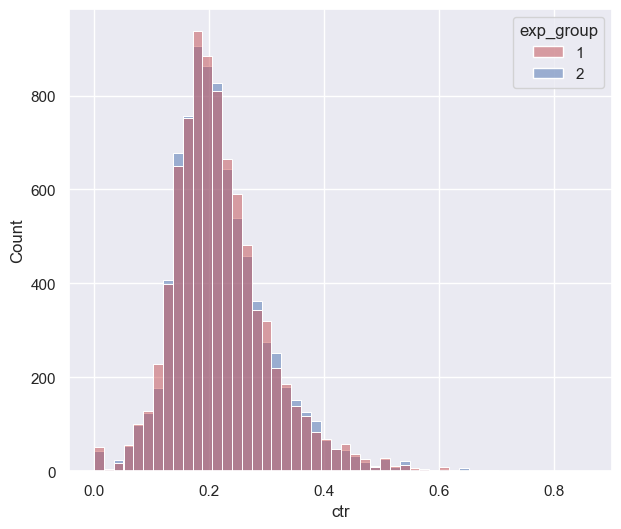

In [7]:
#распределение ctr по двум группам
sns.set(rc={'figure.figsize':(7,6)}, font_scale = 1)

groups = sns.histplot(data = data_for_AA, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False, bins = 50)

In [8]:
%%time
#случайное взятие подвыборок без повторения длины 500 из исходных выборок
p_values = list()
alpha = 0.05      #уровень значимости
n_samples = 500   #размер подвыборок
n_tests = 10000   #количество тестов
for _ in range(n_tests):
    p_values.append(stats.ttest_ind(data_for_AA[data_for_AA.exp_group==1].ctr.sample(n_samples).values,
                                    data_for_AA[data_for_AA.exp_group==2].ctr.sample(n_samples).values,
                                    equal_var = False)[1])

CPU times: total: 41.5 s
Wall time: 52 s


p-value ниже 0.05 в 4.580% случаев


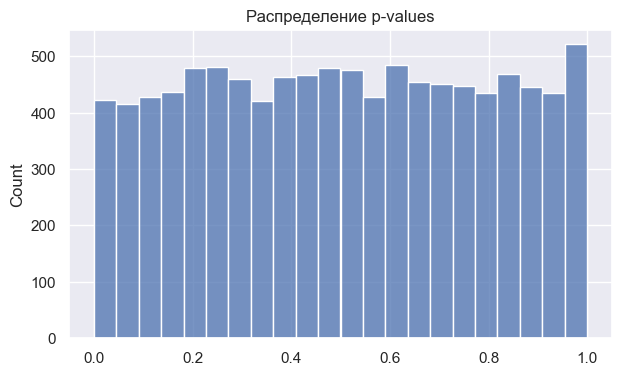

In [9]:
sns.set(rc={'figure.figsize':(7,4)}, font_scale = 1)

pvalues = sns.histplot(p_values).set(title = 'Распределение p-values')

otvet = sum(np.array(p_values) <= alpha)/n_tests
print(f'p-value ниже 0.05 в {otvet*100:.3f}% случаев')

#### Cистема сплитования работает корректно, так как только в около 5% случаев (при принятом a = 0.05) была отвергнута нулевая гипотеза (ошибка первого рода) в результате случайного ложного срабатывания.

Далее посмотрим на те же группы пользователей во время проведения эксперимента, где для 2 группы вводился новый алгоритм рекомендаций.

In [10]:
#получение данных для AБ теста
q_AB = '''
select user_id, 
       exp_group,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2024-05-03' and toDate(time) <= '2024-05-09'
and exp_group in (1,2)
group by user_id, exp_group
'''

In [11]:
data_for_AB = ph.read_clickhouse(q_AB, connection = connection)

In [12]:
data_for_AB

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596
...,...,...,...,...,...
19892,17146,2,0,10,0.000000
19893,30872,1,11,59,0.186441
19894,25383,2,42,127,0.330709
19895,139020,2,17,41,0.414634


#### Cравним распределения данных до и во время проведения эксперимента

In [13]:
means_ctr_prev = data_for_AA.groupby('exp_group').agg({'ctr':'mean'}).values
means_ctr = data_for_AB.groupby('exp_group').agg({'ctr':'mean'}).values

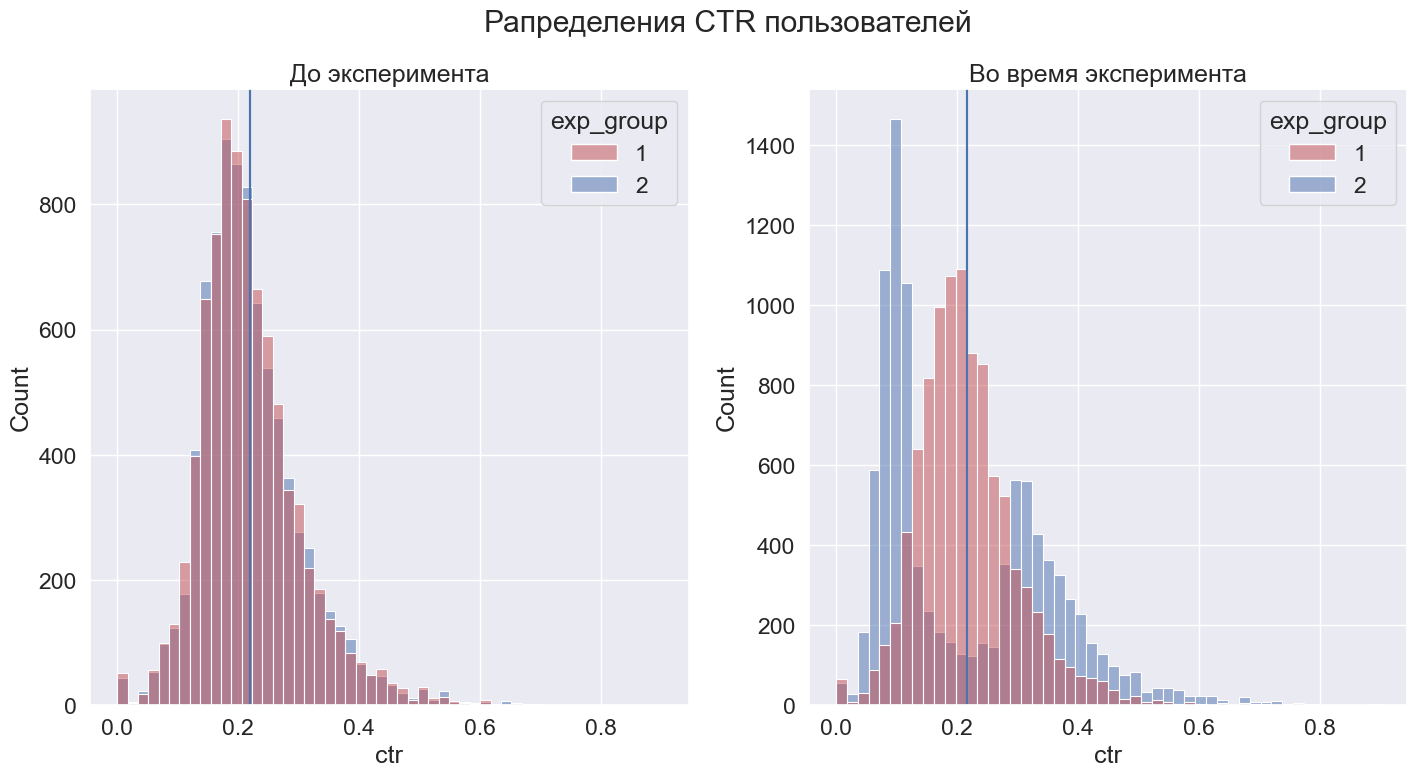

In [14]:
sns.set(font_scale = 1.5)
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(17,8))
figure.suptitle('Рапределения CTR пользователей')

axes[0].set_title('До эксперимента')
groups_prev = sns.histplot(data = data_for_AA, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False, ax=axes[0], bins = 50)
axes[0].axvline(means_ctr_prev[0])
axes[0].axvline(means_ctr_prev[1])

axes[1].set_title('Во время эксперимента')
groups = sns.histplot(data = data_for_AB, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False, ax=axes[1], bins = 50)
axes[1].axvline(means_ctr[0])
axes[1].axvline(means_ctr[1])

#### При проверке "на глаз" уже можно сказать, что CTR по пользователям в группе 2, где тестировлся новый алгоритм рекомендаций, изменился. Пользователи разделились на две подгруппы, у одних CTR вырос, у других упал. Среднее значение при этом не изменилось.

In [15]:
# t-тест
def t_test(A,B):
    t = stats.ttest_ind(A,B,equal_var = False) #equal_var дисперсии не обязательно равны
    return t

# тест Манна-Уитни
def m_test(A,B):
    m = stats.mannwhitneyu(A,B)
    return m

### t-тест CTR по пользователям в группе

In [16]:
print(t_test(data_for_AB[data_for_AB.exp_group==1].ctr,data_for_AB[data_for_AB.exp_group==2].ctr))

TtestResult(statistic=0.4051491913112757, pvalue=0.685373331140751, df=15811.22649797086)


#### t-test показал отсутствие значимых различий между выборками, нулевая гипотеза принимается, так как p-value больше 0.05. Результат теста нельзя считать корректным, так как распределение 2-й группы пользователей очень сильно отлично от нормального, оно бимодально, скошено, на таких исходных данных t-тест работает нехорошо.

### Тест Манна-Уитни CTR по пользователям в группе

In [17]:
print(m_test(data_for_AB[data_for_AB.exp_group==1].ctr,data_for_AB[data_for_AB.exp_group==2].ctr))

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)


#### p-value сильно меньше 0.05, следовательно, нулевая гипотеза отвергается. Тест Манна-Уитни показывает наличие статистически значимых различий CTR по пользователям.

### Метрика linearized likes
Считаем глобальный $CTRglobal$ в контрольной группе. Далее в каждой группе считаем следующую метрику по каждому пользователю: 

$$linearizedLikes = likes - CTRglobal \cdot views$$

Подобную линиаризацию можно проводить для метрик-отношений.
Гарантируется, что если тест на этой метрике показал значимые различия, то изменения есть и в метрике исходной.

In [18]:
def get_linear_likes(likes, views, ctr_control):
    return likes - ctr_control * views

In [19]:
group1 = data_for_AB[data_for_AB.exp_group==1]
group2 = data_for_AB[data_for_AB.exp_group==2]

control_CTR = group1.likes.sum() / group1.views.sum()
linear_metric1 = get_linear_likes(group1.likes, group1.views, control_CTR)
linear_metric2 = get_linear_likes(group2.likes, group2.views, control_CTR)

<Axes: ylabel='Count'>

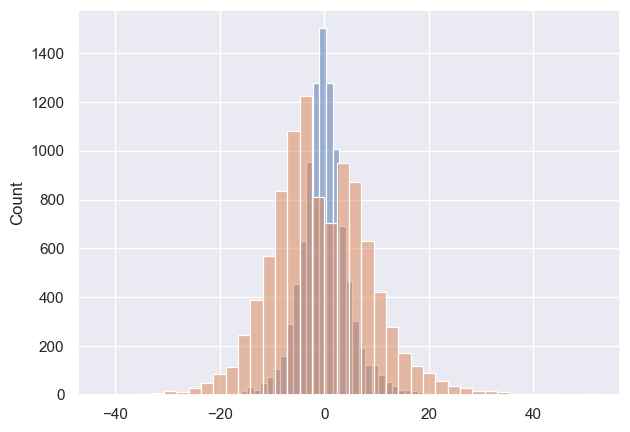

In [20]:
sns.set(rc={'figure.figsize':(7,5)})
sns.histplot(linear_metric1,
              alpha=0.5,
              kde=False, bins = 40)
sns.histplot(linear_metric2,
              alpha=0.5,
              kde=False, bins = 40)

In [21]:
print(t_test(linear_metric1,linear_metric2))

TtestResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09, df=14482.887340383999)


#### На метрике linearizedLikes t-тест увидел статистически значимые различия между группами.

### Пуассоновский бутстреп
Возьмем из групп псевдовыборки с возвращением такой же длины, что и исходные выборки, для каждой псевдовыборки посчитаем глобальный CTR.

Сгенерируем для каждого объекта выборки значение - попал он или не попал в псевдовыборку. Вероятность того, что значение попадет в псевдовыборку 1/(длина выборки). n испытаний Бернулли с вероятностью успеха 1/n моделируется Биномиальным распределением. Биномиальное распределение при очень маленькой вероятности успеха 1/n аппроксимируется распределением Пуассона с параметром 1. Поэтому для генерации количества попаданий используем распределение Пуассона.

In [22]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    # генерация количества попаданий в псевдовыборку
    #всего 2000 псевдовыборок
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    # расчет глобального CTR для полученных псевдовыборок
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [23]:
likes1 = data_for_AB[data_for_AB['exp_group'] == 1].likes.values
views1 = data_for_AB[data_for_AB['exp_group'] == 1].views.values
likes2 = data_for_AB[data_for_AB['exp_group'] == 2].likes.values
views2 = data_for_AB[data_for_AB['exp_group'] == 2].views.values

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

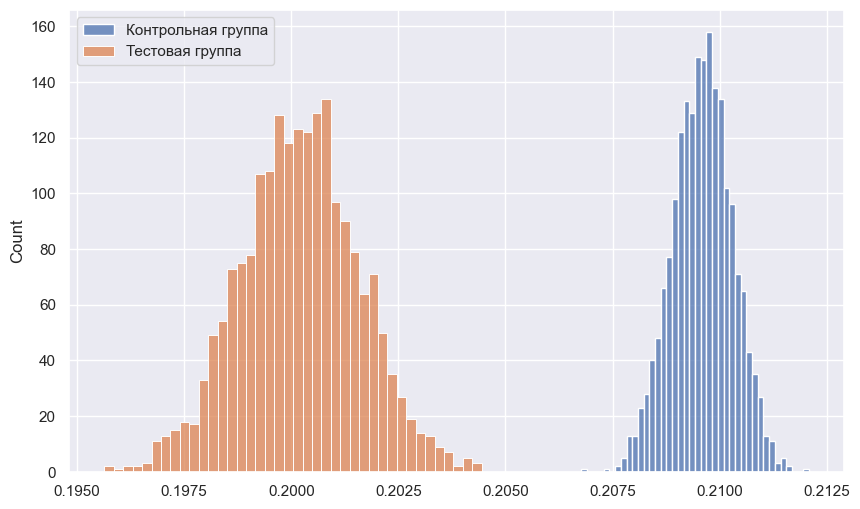

In [24]:
sns.set(rc={'figure.figsize':(10,6)}, font_scale = 1)
sns.histplot(ctr1, label = 'Контрольная группа',bins = 40)
sns.histplot(ctr2, label = 'Тестовая группа',bins = 40)
plt.legend()

#### По графикам распределений глобального CTR по группам видно, что они не пересекаются, следовательно, статистически значимые различия между группами есть. Нулевая гипотеза отвергается. Меры центральной тенденции распределения глобального CTR тестовой группы ниже, чем контрольной группы. То есть глобальный CTR во время проведения эксперимента стал ниже.

Text(0.5, 1.0, 'Распределения разницы глобальных CTR')

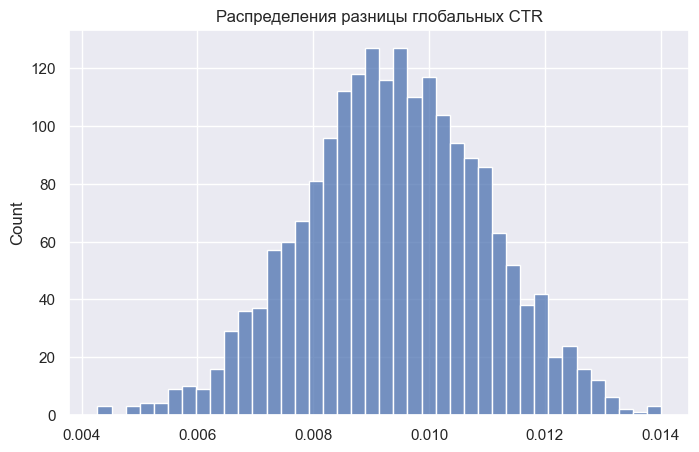

In [25]:
sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1)
sns.histplot(ctr1 - ctr2, bins = 40).set_title('Распределения разницы глобальных CTR')

#### Распределение разницы глобального CTR контрольной и тестовой групп больше 0.

### Бакетное преобразование
Разделим каждую группу пользователей на 16 бакетов. Для каждого бакета посчитаем медианное значение CTR.

In [26]:
#хэширование с солью для разделения на бакеты
my_salt = 'exp_mess_1'
def split(id, salt = my_salt, n_groups = 5):
    test_id = str(id) + '-' + salt
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [27]:
group1['bucket'] = group1['user_id'].apply(lambda id: split(id, n_groups=40))
group2['bucket'] = group2['user_id'].apply(lambda id: split(id, n_groups=40))

In [28]:
group1

,user_id,exp_group,likes,views,ctr,bucket
0,109963,1,3,15,0.200000,0
1,26117,1,32,141,0.226950,39
2,138232,1,18,73,0.246575,11
3,18392,1,7,32,0.218750,21
4,26295,1,39,141,0.276596,14
...,...,...,...,...,...,...
19886,31540,1,7,39,0.179487,33
19887,23359,1,12,32,0.375000,26
19890,110956,1,3,16,0.187500,16
19891,132567,1,52,326,0.159509,14


In [29]:
buckets_ctr1 = group1.groupby('bucket').ctr.quantile(0.5)
buckets_ctr2 = group2.groupby('bucket').ctr.quantile(0.5)

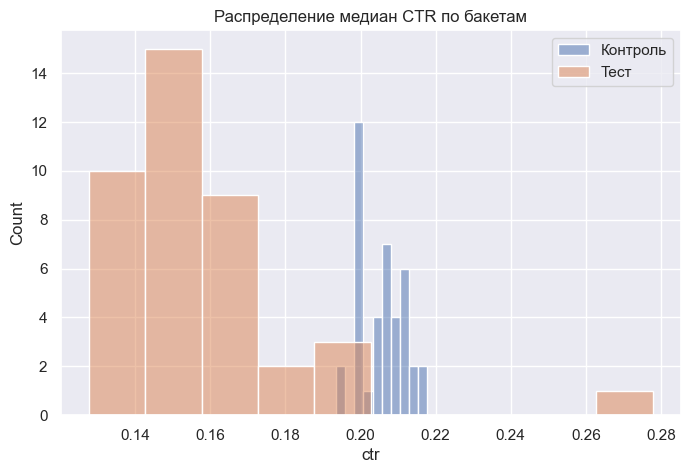

In [30]:
sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1)
sns.histplot(buckets_ctr1, bins = 10,
              alpha=0.5,
              kde=False, label = 'Контроль').set_title('Распределение медиан CTR по бакетам')         

sns.histplot(buckets_ctr2, bins = 10,
              alpha=0.5,
              kde=False, label = 'Тест')    
plt.legend()

In [31]:
#t-тест
print(t_test(buckets_ctr1,buckets_ctr2))

# тест Манна-Уитни
print(m_test(buckets_ctr1,buckets_ctr2))

TtestResult(statistic=11.084282144105543, pvalue=3.83428410071945e-14, df=42.67675449908108)
MannwhitneyuResult(statistic=1549.5, pvalue=5.08616442250275e-13)


#### Оба теста показывают наличие значимых различий между группами. p-value меньше 0.05, нулевая гипотеза отвергается.

#### Введение нового алгоритма дало прирост CTR только у некоторой части пользователей, у большенства же CTR упал. Если смотреть глобально, то новый алгоритм во 2 группе привел к падению CTR. Для того, чтобы понять, почему так произошло, необходимо провести дополнительное исследование. На данном этапе не стоит раскатывать обновление на всех пользователей. Нулевая гипотаза отвергается, обнаружено статистически значимое падение метрики.